In [0]:
pip install pydicom

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/')
#os.chdir('/content/drive/My Drive/RSNA')

In [0]:
train_path='/content/drive/My Drive/Colab Notebooks/Crop/Train/'
validation_path= '/content/drive/My Drive/Colab Notebooks/Crop/Validate/'

In [0]:
import keras
from keras.applications.densenet import DenseNet121
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,Adamax
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from generator import DataGenerator

Using TensorFlow backend.


In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.2)
       # horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Crop/Train',
        target_size=(256, 256),
        batch_size=16,color_mode='rgb',
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Crop/Validate',
        target_size=(256, 256),
        batch_size=16,color_mode='rgb',
        class_mode='binary')

Found 3707 images belonging to 2 classes.
Found 593 images belonging to 2 classes.


In [0]:
#model_prn.compile(optimizer=optimizer, loss=[focal_loss(alpha=.25, gamma=2)])

In [0]:
input_shape=(256,256,3)
#input_shape=(256,256,3)
img_in = Input(input_shape)              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='max') 

W0616 12:59:29.107585 140188682295168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 12:59:29.128756 140188682295168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 12:59:29.135445 140188682295168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 12:59:29.158184 140188682295168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 12:59:29.159005 1401886822

In [0]:
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,Conv2D
from keras.layers import BatchNormalization,Activation
from keras.layers import MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Flatten
from keras.optimizers import adam
from keras import optimizers
import keras

In [0]:
def preprocess_input_densenet(self, x):
        from keras.applications.densenet import preprocess_input
        X = np.expand_dims(x, axis=0)
        X = preprocess_input(X)
        return X[0]    

In [0]:
from keras import backend as K

In [0]:
def focal_loss(gamma=2., alpha=.25):
  def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    pt_1 = K.clip(pt_1, 1e-3, .999)
    pt_0 = K.clip(pt_0, 1e-3, .999)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

  return focal_loss_fixed

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
for layer in model.layers:
  layer.trainable = True

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
#weight_path="{}_weights.best.hdf5".format('lung_opacity')

#checkpoint = ModelCheckpoint(weight_path, monitor='loss', verbose=1, 
 #                            save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited

checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/first_try_1.h5', monitor='val_loss',verbose=1,save_best_only=True, 
                              save_weights_only=True,mode='val_acc')

callbacks_list = [checkpoint,reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:407: RuntimeWarning: ModelCheckpoint mode val_acc is unknown, fallback to auto mode.
  RuntimeWarning)


In [0]:


# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f801c0846d8> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7feb572080> True
<keras.layers.convolutional.Conv2D object at 0x7f7feb572a90> True
<keras.layers.normalization.BatchNormalization object at 0x7f7feb572e48> True
<keras.layers.core.Activation object at 0x7f7feb578c50> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7fea28f438> True
<keras.layers.pooling.MaxPooling2D object at 0x7f7fea2c7da0> True
<keras.layers.normalization.BatchNormalization object at 0x7f7feb5788d0> True
<keras.layers.core.Activation object at 0x7f7fe9550cc0> True
<keras.layers.convolutional.Conv2D object at 0x7f7fe9458550> True
<keras.layers.normalization.BatchNormalization object at 0x7f7fe94bafd0> True
<keras.layers.core.Activation object at 0x7f7fe9478668> True
<keras.layers.convolutional.Conv2D object at 0x7f7fe93c9550> True
<keras.layers.merge.Concatenate object at 0x7f7fe93a9f98> True
<keras.layers.normalization.BatchNormaliza

In [0]:
# Create the model
model_Densenet_full2 = Sequential()
 
# Add the vgg convolutional base model
model_Densenet_full2.add(model)
 
# Add new layers
#model_vgg_flow.add(Flatten())
#model_Densenet_full2.add(Dropout(0.25))
model_Densenet_full2.add(Dense(256, activation='relu'))
model_Densenet_full2.add(Dropout(0.25))
model_Densenet_full2.add(Dense(100, activation='relu'))
model_Densenet_full2.add(Dropout(0.15))
model_Densenet_full2.add(Dense(1, activation='sigmoid'))

#model_vgg_flow.add(Dense(1, activation='softmax')) 
# Show a summary of the model. Check the number of trainable parameters
model_Densenet_full2.summary()

W0616 12:59:56.590923 140188682295168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 7,325,705
Trainable params: 7,242,057
Non-trainable params: 83,648
_____________________________________________________________

In [0]:
#adam=optimizers.Adam(lr=0.0001)
#model_Densenet_full2.compile(optimizer=adam,loss='binary_crossentropy',metrics=[keras.metrics.binary_accuracy])

import tensorflow as tf

In [0]:

adam=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

In [0]:
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_Densenet_full2.compile(optimizer=adam,loss=[focal_loss(alpha=.25, gamma=2)],metrics=['accuracy'])

model_Densenet_full2.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])


W0616 12:59:56.703248 140188682295168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 12:59:56.719183 140188682295168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_Densenet_full2.compile(optimizer=sgd,loss=focal_loss,metrics=['accuracy'])

batch_size=128
model_Densenet_full2.fit_generator(
        train_generator,
        steps_per_epoch=4800 // batch_size,
        epochs=100,
        callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=440//batch_size)
model_Densenet_full2.save_weights('/content/drive/My Drive/unfreeze_all_sgd_001.h5')  # always save your weights after training or during training

Epoch 1/100
37/37 [==============================] - 42s 1s/step - loss: 1.4477 - acc: 0.6216 - val_loss: 2.1891 - val_acc: 0.6458

Epoch 00001: val_loss improved from inf to 2.18909, saving model to /content/drive/My Drive/Colab Notebooks/first_try_1.h5
Epoch 2/100
37/37 [==============================] - 14s 370ms/step - loss: 0.6659 - acc: 0.7280 - val_loss: 0.5675 - val_acc: 0.7917

Epoch 00002: val_loss improved from 2.18909 to 0.56753, saving model to /content/drive/My Drive/Colab Notebooks/first_try_1.h5
Epoch 3/100
37/37 [==============================] - 17s 461ms/step - loss: 0.6675 - acc: 0.7179 - val_loss: 0.4758 - val_acc: 0.8333

Epoch 00003: val_loss improved from 0.56753 to 0.47578, saving model to /content/drive/My Drive/Colab Notebooks/first_try_1.h5
Epoch 4/100
37/37 [==============================] - 17s 457ms/step - loss: 0.4927 - acc: 0.7770 - val_loss: 0.3714 - val_acc: 0.8333

Epoch 00004: val_loss improved from 0.47578 to 0.37141, saving model to /content/drive

In [0]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [0]:
import os
import cv2 

data = []
labels = []

patientID=[]
filename=[]
ValDir= '/content/drive/My Drive/Colab Notebooks/Crop/Validate/'

# loop over the input images
dirs = os.listdir(ValDir) 
for dir in dirs:
    absDirPath = os.path.join(os.path.sep,ValDir, dir)
    images = os.listdir(absDirPath)
    for imageFileName in images:
        
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(ValDir, dir, imageFileName)
        print(imageFullPath)
        img = load_img(imageFullPath)
        arr = img_to_array(img)  #Numpy array with shape (233,233,3)
        arr = cv2.resize(arr, (256,256)) #Numpy array with shape (HEIGHT, WIDTH,3)
        print(arr.shape)
        data.append(arr)
        patientID.append(imageFileName.split('/')[-1].split('.')[0])
        print(patientID)
        filename.append(imageFullPath)
        
        #label = classes_to_int(dir)
        if(dir== 'Pneumonia'):
          label=1
        else:
          label=0
        #print(label)
        labels.append(label)

/content/drive/My Drive/Colab Notebooks/Crop/Validate/Pneumonia/e92d7e53-f191-41af-a86b-8da6c7734386.png
(256, 256, 3)
['e92d7e53-f191-41af-a86b-8da6c7734386']
/content/drive/My Drive/Colab Notebooks/Crop/Validate/Pneumonia/8f1e9f08-630d-4ea4-b448-1d465801d7e4.png
(256, 256, 3)
['e92d7e53-f191-41af-a86b-8da6c7734386', '8f1e9f08-630d-4ea4-b448-1d465801d7e4']
/content/drive/My Drive/Colab Notebooks/Crop/Validate/Pneumonia/3eb19434-abba-4221-bc02-545d97b9a093.png
(256, 256, 3)
['e92d7e53-f191-41af-a86b-8da6c7734386', '8f1e9f08-630d-4ea4-b448-1d465801d7e4', '3eb19434-abba-4221-bc02-545d97b9a093']
/content/drive/My Drive/Colab Notebooks/Crop/Validate/Pneumonia/f2fda506-7c73-4746-a7a6-59968f1e8de2.png
(256, 256, 3)
['e92d7e53-f191-41af-a86b-8da6c7734386', '8f1e9f08-630d-4ea4-b448-1d465801d7e4', '3eb19434-abba-4221-bc02-545d97b9a093', 'f2fda506-7c73-4746-a7a6-59968f1e8de2']
/content/drive/My Drive/Colab Notebooks/Crop/Validate/Pneumonia/8b6be652-97a4-4149-bd5a-92464ba031ef.png
(256, 256, 3)
[

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
print(len(images))
print('Number of images :-',len(data))
print('Number of Labels',len(labels))
print('Number of patientID :-',len(patientID))
print(len(filename))

300
Number of images :- 593
Number of Labels 593
Number of patientID :- 593
593


In [0]:
Valid_df = pd.DataFrame({ 
                        'patientId':patientID,
                       'images':data,
                        'Labels': labels,
                         'Filenames':filename
                         })

In [0]:
Valid_df['Labels'].value_counts()

0    300
1    293
Name: Labels, dtype: int64

In [0]:
Valid_df.head(5)

patientId  ...    preds
0  e92d7e53-f191-41af-a86b-8da6c7734386  ...  [[1.0]]
1  8f1e9f08-630d-4ea4-b448-1d465801d7e4  ...  [[1.0]]
2  3eb19434-abba-4221-bc02-545d97b9a093  ...  [[1.0]]
3  f2fda506-7c73-4746-a7a6-59968f1e8de2  ...  [[1.0]]
4  8b6be652-97a4-4149-bd5a-92464ba031ef  ...  [[1.0]]

[5 rows x 5 columns]

In [0]:
#pred_Y = pneu_model.predict(valid_X, 
 #                         batch_size = BATCH_SIZE, 
  #                        verbose = True)

In [0]:
y_preds=[]
for img in Valid_df['images']:
  img=img.reshape(-1,256,256,3)
  pred_1=model_Densenet_full2.predict(img)
  y_preds.append(pred_1)

In [0]:
Valid_df['preds']=y_preds

In [0]:

Valid_df['Labels'].value_counts()
y_preds_1=y_preds

In [0]:
preds=[]
for i, predicted in enumerate(y_preds_1):
  if (predicted[0][0])>=0.4:
    value=1
    preds.append(value)
      
    
  else :
    value=0
    preds.append(value)

In [0]:
y_val=Valid_df['Labels']

In [0]:
from sklearn.metrics import confusion_matrix,classification_report
print("\nConfusion_Marix is :\n",confusion_matrix(y_val, preds))
print("\nClassification_Report is :\n",classification_report(y_val,preds))


Confusion_Marix is :
 [[  0 300]
 [  0 293]]

Classification_Report is :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.49      1.00      0.66       293

    accuracy                           0.49       593
   macro avg       0.25      0.50      0.33       593
weighted avg       0.24      0.49      0.33       593



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


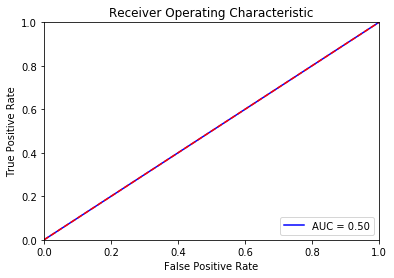

In [0]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [0]:
#pred_Y = model_Densenet_full2.predict(Valid_df[], 
 #                         batch_size = 100, 
  #                        verbose = True)

In [0]:

from keras.applications.densenet import DenseNet201

model201 = DenseNet201(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 


# Create the model
model_Densenet_full201 = Sequential()
 
# Add the vgg convolutional base model
model_Densenet_full201.add(model201)
 
# Add new layers
#model_vgg_flow.add(Flatten())
model_Densenet_full201.add(Dropout(0.15))
model_Densenet_full201.add(Dense(128, activation='relu'))
#model_Densenet.add(Dropout(0.25))
#model_Densenet.add(Dense(128, activation='relu'))
model_Densenet_full201.add(Dropout(0.25))
model_Densenet_full201.add(Dense(1, activation='sigmoid'))

#model_vgg_flow.add(Dense(1, activation='softmax')) 
# Show a summary of the model. Check the number of trainable parameters
model_Densenet_full201.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               245888    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 18,568,001
Trainable params: 18,338,945
Non-trainable params: 229,056
_________________________________________________________________


In [0]:
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_Densenet_full201.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
batch_size=100
model_Densenet_full201.fit_generator(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=25)
model_Densenet_full201.save_weights('/content/drive/My Drive/densenet_201_sgd_0001.h5')  # always save your weights after training or during training



Epoch 1/20
10/10 [==============================] - 48s 5s/step - loss: 0.6949 - acc: 0.5563 - val_loss: 0.6974 - val_acc: 0.5375
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 0.6730 - acc: 0.5822 - val_loss: 0.7261 - val_acc: 0.5013
Epoch 3/20
10/10 [==============================] - 9s 879ms/step - loss: 0.7064 - acc: 0.5438 - val_loss: 0.6615 - val_acc: 0.5948
Epoch 4/20
10/10 [==============================] - 9s 918ms/step - loss: 0.6688 - acc: 0.5812 - val_loss: 0.6625 - val_acc: 0.5550
Epoch 5/20
10/10 [==============================] - 9s 898ms/step - loss: 0.6263 - acc: 0.6375 - val_loss: 0.6506 - val_acc: 0.5506
Epoch 6/20
10/10 [==============================] - 9s 887ms/step - loss: 0.5762 - acc: 0.7000 - val_loss: 0.6345 - val_acc: 0.6234
Epoch 7/20
10/10 [==============================] - 9s 897ms/step - loss: 0.6111 - acc: 0.7062 - val_loss: 0.6068 - val_acc: 0.6925
Epoch 8/20
10/10 [==============================] - 9s 904ms/step - loss: 0.5856

In [0]:
!ls

Classfiication_Report.ipynb		   RSNA_EDA_crop.ipynb
Crop					   stage_2_detailed_class_info.csv
first_try_1.h5				   stage_2_train_labels.csv
pneumonia				   test
RSNA_basemodel.ipynb			   train
RSNA_Classification_Chexnet_and_EDA.ipynb  training
RSNA_Classification_Chexnet_crop.ipynb	   Validation


In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y[:,0])
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y[:,0]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')
fig.savefig('roc_valid.pdf')

NameError: ignored